In [1]:
import glob
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import json
import os
import h5py
from skimage.transform import resize
import ast

In [2]:
r_dir = '/mnt/data/dbext/covid19/images/'
dt = pd.read_csv('/mnt/ssd/covid19_20200527_with_test_date_qc_with_reports.csv', low_memory=False)
h5_file = '/mnt/ssd/covid19_20200527.hdf5'

# dt = dt.drop(dt.index[-1])
dt['pos'] = dt['Unnamed: 0']

In [5]:
import ast
# rs = pd.read_csv('/mnt/data/dbext/covid19/images/derivatives/labels/labels_covid19_posi.tsv', sep='\t')

# Turns the string lists into diagnosis
al = []
diags = []
locs = []
al_locs = []


for x in dt['Labels']:
    if not isinstance(x, str):
        diags.append('')
    else:
        r = ast.literal_eval(x)
        rn = [n.strip() for n in r]
        diags.append(rn)
        al.extend(rn)

        
for x in dt['Localizations']:
    if not isinstance(x, str):
        locs.append('')   
    else:
        r = ast.literal_eval(x)
        rn = [n.strip() for n in r]
        locs.append(rn)
        al_locs.extend(rn)

        
dt['Diagnosis'] = diags
dt['Locs'] = locs

In [6]:
# Since one file can have several reports associated, keep only the first one
dt_images = dt.drop_duplicates(subset='File', keep='first')
dt_studies = dt.drop_duplicates(subset='Session', keep='first', inplace=False)
dt_subjects = dt.drop_duplicates(subset='Subject', keep='first', inplace=False)

In [7]:
len(dt_studies)

2428

In [8]:
print("%i subjects, %i  studies and %i series" % 
(len(list(set(dt_images['Subject']))),    len(list(set(dt_images['Session']))), len(dt_images)) )
ctr = dt_studies['Modality'].value_counts()
print(" %i CX, %i DX and %i CT" % (ctr["['CR']"], ctr["['DX']"], ctr["['CT']"]))
ctr = dt_images['Modality'].value_counts()
print("Images: %i CX, %i DX and %i CT" % (ctr["['CR']"], ctr["['DX']"], ctr["['CT']"]))


1310 subjects, 2428  studies and 5380 series
 1380 CX, 885 DX and 163 CT
Images: 1952 CX, 1189 DX and 2239 CT


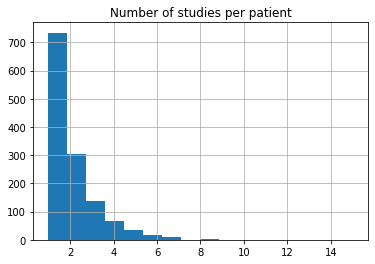

In [11]:
dt_studies['Subject'].value_counts().hist(bins=16)
plt.title('Number of studies per patient')
plt.savefig('hist_studies.png')

In [12]:
np.mean(dt_studies['Subject'].value_counts())

1.8534351145038168

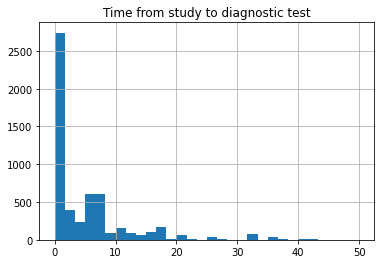

In [13]:
plt.hist(pd.to_timedelta(dt['DStudy_Test']).dt.days, bins=30)
plt.title('Time from study to diagnostic test')
plt.grid('True')
plt.savefig('Time Study Diagnostic Test')

In [14]:
np.mean(pd.to_timedelta(dt['DStudy_Test']).dt.days)

5.031312217194571

In [15]:
nf = dt_subjects["Patient's Sex"].value_counts()["['F']"]
pf = nf*100.0/len(dt_subjects)
print("%i patients were female (%.02f%%)" % (nf, pf))

602 patients were female (45.95%)


 mean age 63.11 (\pm 16.75)


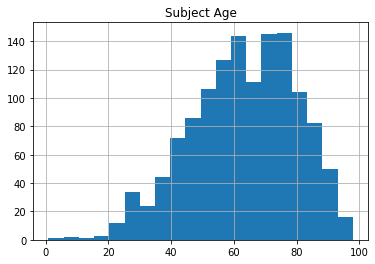

In [16]:
ages = []
for x in dt_subjects["Patient's Birth Date"].values:
    if type(x) == type('str'):
        ages.append(2020 - int(ast.literal_eval(x)[0])/10000)


ma = np.mean(ages)
stda = np.std(ages)
print(" mean age %.02f (\\pm %.02f)" % (ma, stda))
plt.hist(ages, bins=20)
plt.grid(True)
plt.title('Subject Age')
plt.savefig('hist_age.png')

In [17]:
dt_studies['MF_Model'] = dt_studies['Manufacturer'] + " " + dt_studies["Manufacturer's Model Name"]
print(dt_studies['MF_Model'].value_counts().to_latex().replace("[","").replace("]","").replace("'",""))

\begin{tabular}{lr}
\toprule
{} &  MF\_Model \\
\midrule
KONICA MINOLTA 0862                        &       342 \\
GMM ACCORD DR                              &       255 \\
SIEMENS SIEMENS FD-X                       &       247 \\
Agfa DR 14e C - 1200ms                     &       161 \\
Agfa DX-M                                  &       161 \\
"GE Healthcare" "Thunder Platform"         &       150 \\
Philips Medical Systems DigitalDiagnost    &       133 \\
Philips Medical Systems PCR Eleva          &       113 \\
Agfa 3543EZE                               &       112 \\
Carestream Health DRX-1                    &        87 \\
KONICA MINOLTA CS-7                        &        77 \\
SIEMENS SOMATOM go.Up                      &        69 \\
Agfa Pixium\_4343E\_CSI                      &        59 \\
Agfa CR30-X                                &        39 \\
Canon Inc. CXDI Control Software NE        &        37 \\
TOSHIBA Aquilion                           &        36 \\
Philips Digit

/home/ggonzale/miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
dt_dx_cr = dt[ (dt.Type == 'dx') | (dt.Type == 'cr')]
dt_dx_cr['Photometric Interpretation'].value_counts()

['MONOCHROME2']    2427
['MONOCHROME1']     751
Name: Photometric Interpretation, dtype: int64

In [19]:
dt['prueba'].value_counts()

PCR    5505
ACT       7
IGG       7
IGM       6
Name: prueba, dtype: int64

In [25]:
dt['suboptimal'] = ['suboptimal study' in x for x in dt['Diagnosis']]

In [26]:
al_diags = []
for i, r in dt_studies.iterrows():
    al_diags.extend(r['Diagnosis'])

In [27]:
img_data = h5py.File(h5_file, 'r')['images']

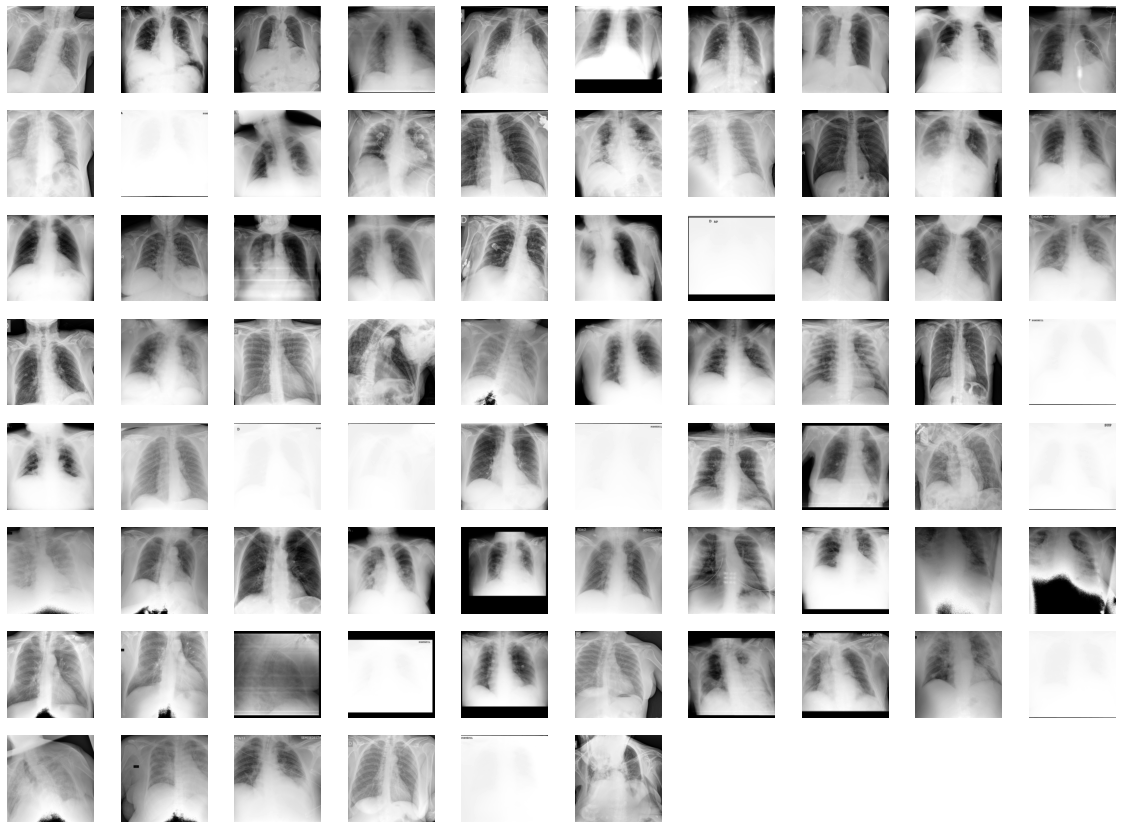

In [28]:
# Images tagged as PA or P on the dicom field 'View Position', but tagged as L using the deep learning method
# They are indeed lateral
discs_pa = dt[ (dt['suboptimal'] == True) & (dt['Type'] != 'ct') & (dt['Position_Manual'] == 'PA')]
len(discs_pa)
discs_pa = discs_pa.drop_duplicates(subset='File', keep='first')

plt.figure(figsize=(20,15))
for i in range(0,len(discs_pa[0:80])):
    plt.subplot(8,10,i+1)
    plt.imshow(img_data[discs_pa.iloc[i]['h5_idx']], cmap='gray')
    plt.axis('off')

In [29]:
 dt['Position_Manual'].value_counts()

PA    2377
L      801
Name: Position_Manual, dtype: int64

In [30]:
discs_pa.iloc[7].Report

'rx en decubito de mala calidad con paciente rotada hacia la derecha aunque sin identificar opacidades pulmonares de nueva aparicion .'

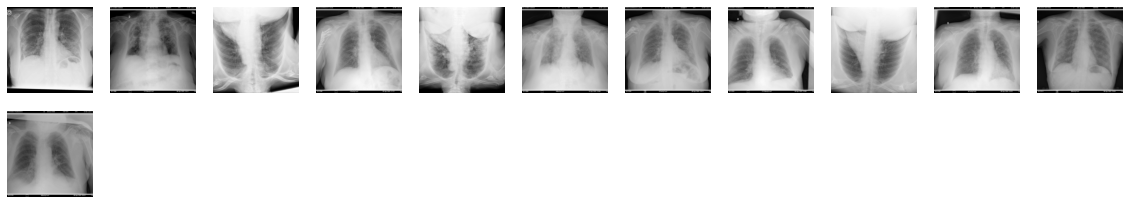

In [31]:
# Images tagged as PA or P on the dicom field 'View Position', but tagged as L using the deep learning method
# They are indeed lateral
discs_pa = dt[ (dt['Exclude'] == True) & (dt['Type'] != 'ct')]
len(discs_pa)
discs_pa = discs_pa.drop_duplicates(subset='File', keep='first')

plt.figure(figsize=(20,15))
for i in range(0,len(discs_pa)):
    plt.subplot(8,11,i+1)
    plt.imshow(img_data[discs_pa.iloc[i]['h5_idx']], cmap='gray')
    plt.axis('off')

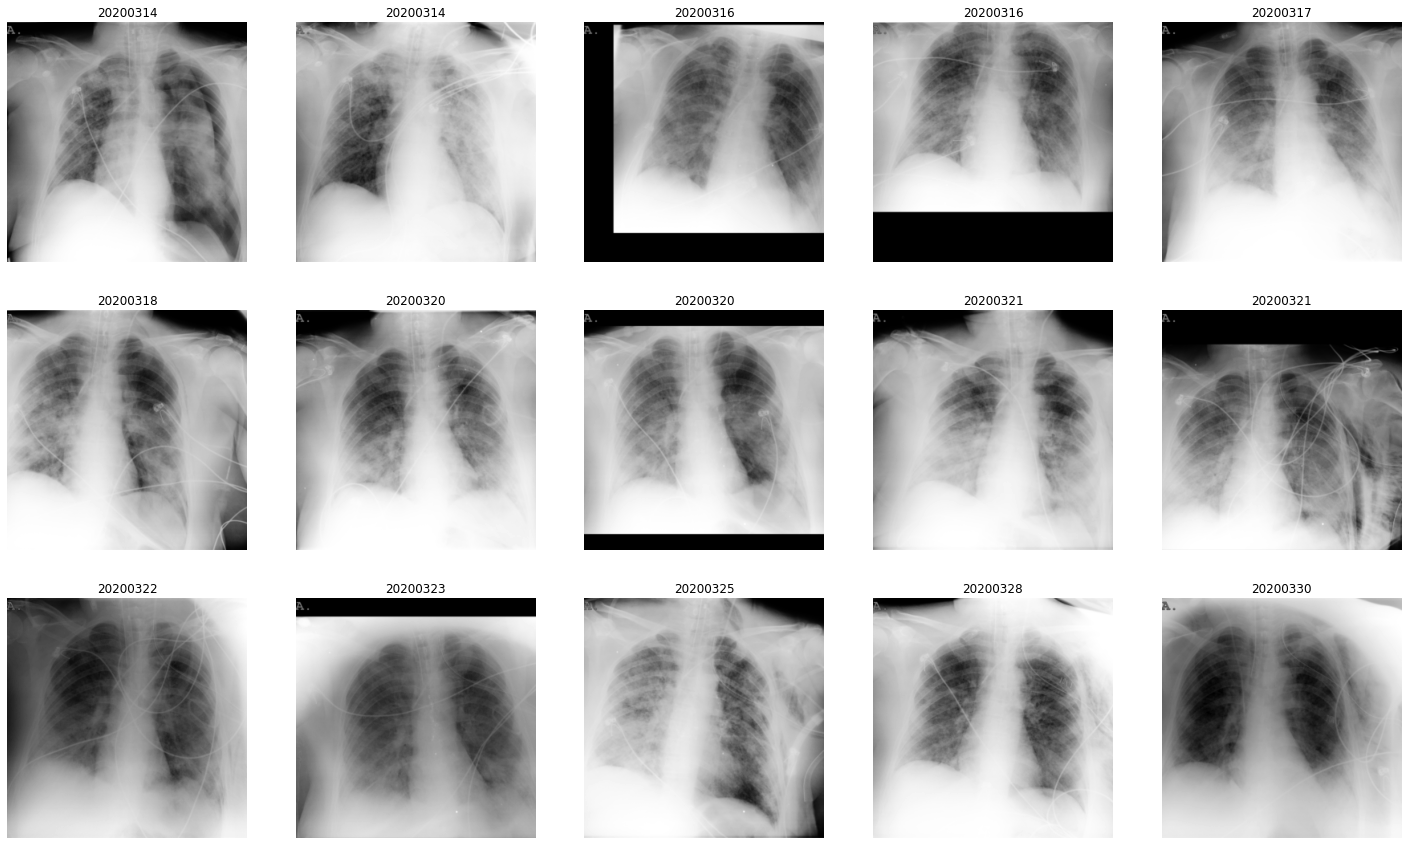

In [35]:
ppn ='sub-S03138'
nimg = 1
plt.figure(figsize=(25,15))
for i, r in dt[dt['Subject']==ppn][['Study Date', 'Type', 'Path', 'h5_idx']].sort_values(by='Study Date').iterrows():
    if nimg > 15:
        continue
    plt.subplot(3,5,nimg)
    plt.imshow(img_data[r['h5_idx']], cmap='gray')
    plt.axis('off')
    plt.title(r['Study Date'].replace("'","").replace("[","").replace("]",""))
    nimg += 1

In [36]:
tests = pd.read_csv('/mnt/data/dbext/covid19/images/derivatives/EHR/sil_reg_covid.tsv', sep='\t')


In [37]:
len(tests)

2518

In [38]:
tests['prueba'].value_counts()

PCR    2425
ACT      35
IGM      29
IGG      29
Name: prueba, dtype: int64

In [39]:
tests[tests['prueba']=='PCR']['resultado'].value_counts()

POSITIVO         1773
NEGATIVO          622
INDETERMINADO      30
Name: resultado, dtype: int64